   <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#4a8fdd;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">TABLE OF CONTENTS</p>   
    
* [1. IMPORTING LIBRARIES](#1)
    
* [2. LOADING DATASET](#2)
    
* [3. DATA CLEANING](#3)
    
    * [3.1. REMOVING URLs](#3.1)    
    * [3.2. LOWER CASE](#3.2)    
    * [3.3. REMOVING PUNCTUATIONS](#3.3)    
    * [3.4. REMOVING EXTRA WHITESPACES](#3.4)    
    * [3.5. REMOVING STOPWORDS](#3.5)    
    * [3.6. APPLYING LEMMATIZATION](#3.6)
    
    
* [4. MOST FREQUENT WORDS IN SPAM DATA](#4)   
    
* [5. MOST FREQUENT WORDS IN HAM DATA](#5) 
      
* [6. BALANCING DATASET](#6)
    
* [7. LABELING CATEGORICAL FEATURE](#7)
    
* [8. TOKENIZATION](#8)
    
* [9. TRAIN TEST SPLIT](#9)
    
* [10. TRAINING DEEP LEARNING MODEL](#10)

* [11. PLOTTING MODEL LAYERS](#11)

* [12. TRAINING MODEL](#12)

* [13. VISUALIZING ACCURACY & LOSS](#13)

* [14. MODEL EVUALATION](#14)

* [15. CLASSIFICATION REPORT](#15)    

* [16. CONFUSION MATRIX](#16)    
    
* [17. MODEL PREDICTION](#17)

<h1> About the Project </h1>

The SMS Spam Collection v.1 (hereafter the corpus) is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam. 
http://www.esp.uem.es/jmgomez/smsspamcorpus/


<a id="1"></a>

## <b>1 <span style='color:#4a8fdd'>|</span> IMPORTING LIBRARIES</b>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

from nlpaug.util import Action
import nlpaug.augmenter.word as word_augmenter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Dropout, Flatten, Bidirectional, LSTM, GRU

import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

<a id="2"></a>

## <b>2 <span style='color:#4a8fdd'>|</span> LOADING DATASET</b>

In [3]:
df = pd.read_csv("./SPAM text message 20170820 - Data.csv")

df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### <b>SHAPE OF DATAFRAME</b>

In [4]:
print(f"Shape of dataset is: {df.shape}")

Shape of dataset is: (5572, 2)


#### <b>UNIQUE CATEGORIES</b>

In [5]:
df['Category'].unique()

array(['ham', 'spam'], dtype=object)

#### <b>CHECKING NAN VALUES</b>

In [6]:
pd.DataFrame(df.isnull().sum(), columns=['Missing Counts'])

,Missing Counts
Category,0
Message,0


<b>NO MISSING VALUE FOUND</b>

#### <b>COUNTS OF CATEGORIES</b>

In [7]:
pd.DataFrame(df['Category'].value_counts()).style.background_gradient()

,count
Category,
ham,4825
spam,747


In [8]:
ham_percentage = (df['Category'].value_counts()[0] * 100) / df.shape[0]
spam_percentage = (df['Category'].value_counts()[1] * 100) / df.shape[0]

print(f'Percentage of ham data is: { round(ham_percentage, 2) }')
print(f'Percentage of spam data is: {round(spam_percentage, 2)}')

Percentage of ham data is: 86.59
Percentage of spam data is: 13.41


In [9]:
fig = px.pie(df, names = "Category",
             title = "<b>Counts in Category</b>",             
             color_discrete_sequence=px.colors.sequential.Blackbody_r,             
             hole = 0.5)

fig.update_layout(title_x = 0.5,
                  title_font = dict(size = 20))

fig.update_traces(textposition='inside',
                  textinfo='percent+label',    
                  textfont_size=15,                  
                  marker=dict(line=dict(color='#000000', width = 1.5)))


fig.show()

<a id="3"></a>

## <b>3 <span style='color:#4a8fdd'>|</span> DATA CLEANING</b>

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
STOPWORDS = stopwords.words('english')
PUNCTUATION = string.punctuation

<a id="3.1"></a>

#### <b>3.1 <span style='color:#4a8fdd'>|</span> REMOVING URLS</b>

In [12]:
def remove_urls(text):    
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [13]:
df['Message'] = df['Message'].apply(remove_urls)

<a id="3.2"></a>

#### <b>3.2 <span style='color:#4a8fdd'>|</span> LOWER CASE</b>

In [14]:
df['Message'] = df['Message'].str.lower()

In [15]:
df.head()

,Category,Message
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


<a id="3.3"></a>

#### <b>3.3 <span style='color:#4a8fdd'>|</span> REMOVING PUNCTUATIONS</b>

In [16]:
def remove_punctuation(series):
    no_punctuation = "".join([word for word in series if word not in PUNCTUATION])
    return no_punctuation

In [17]:
df['Message'] = df['Message'].apply(remove_punctuation)

<a id="3.4"></a>

#### <b>3.4 <span style='color:#4a8fdd'>|</span> REMOVING EXTRA WHITESPACES</b>

In [18]:
def remove_extra_white_spaces(series):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string = series)
    return without_sc

In [19]:
df['Message'] = df['Message'].apply(remove_extra_white_spaces)

<a id="3.5"></a>

#### <b>3.5 <span style='color:#4a8fdd'>|</span> REMOVING STOPWORDS</b>

In [20]:
def remove_stopwords(text):
    no_stopwords = []    
    tokens = word_tokenize(text)
    
    for i in range(len(tokens)):
        if tokens[i] not in STOPWORDS:
            no_stopwords.append(tokens[i])
            
    return " ".join(no_stopwords)

In [21]:
df["Message"] = df["Message"].apply(remove_stopwords)

<a id="3.6"></a>

#### <b>3.6 <span style='color:#4a8fdd'>|</span> APPLYING LEMMATIZATION</b>

In [22]:
def lemmatize_text(text):    
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

In [23]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rla\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
df['Message'] = df['Message'].apply(lemmatize_text)

#### <b>LENGTH OF SENTENCES</b>

In [25]:
df['Message_Length'] = df['Message'].apply(len)

In [26]:
df.head()

,Category,Message,Message_Length
0,ham,go jurong point crazy available bugis great wo...,78
1,ham,ok lar joking wif oni,21
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,135
3,ham,u dun say early hor c already say,33
4,ham,nah dont think go usf life around though,40


<a id="4"></a>

## <b>4 <span style='color:#4a8fdd'>|</span> MOST FREQUENT WORDS IN SPAM DATA</b>

In [27]:
spam_df = df[df['Category'] == 'spam']

spam_df = spam_df.reset_index().drop('index', axis=1)

In [28]:
spam_counter = Counter()

for sent in spam_df['Message'].values:
    for word in sent.split():
        if word.lower() not in STOPWORDS:
            spam_counter[word] += 1

In [29]:
top_spam_words = pd.DataFrame(spam_counter.most_common(20), columns=['Spam Words', 'Counts'])
top_spam_words.style.background_gradient()

,Spam Words,Counts
0,call,356
1,free,216
2,2,173
3,txt,150
4,ur,144
5,text,137
6,mobile,135
7,4,119
8,stop,115
9,claim,113


<a id="5"></a>

## <b>5 <span style='color:#4a8fdd'>|</span> MOST FREQUENT WORDS IN HAM DATA</b>

In [30]:
ham_df = df[df['Category'] == 'ham']

ham_df = ham_df.reset_index().drop('index', axis=1)

In [31]:
ham_counter = Counter()

for sent in ham_df['Message'].values:
    for word in sent.split():
        if word.lower() not in STOPWORDS:
            ham_counter[word] += 1

In [32]:
top_ham_words = pd.DataFrame(ham_counter.most_common(20), columns=['Ham Words', 'Counts'])
top_ham_words.style.background_gradient()

,Ham Words,Counts
0,im,451
1,get,314
2,2,309
3,go,276
4,ltgt,276
5,ok,273
6,dont,265
7,ur,246
8,come,245
9,got,244


<a id="6"></a>

## <b>6 <span style='color:#4a8fdd'>|</span> BALANCING DATASET</b>

<b>AS DATASET IS IMBALANCED, SO BALANCED IT WITH TEXT AUGMENTATION TECHNIQUE</b>

<b>APPLYING WORD AUGMENTER ON SPAM DATA</b> method- Word Synonym Augmentation

In [33]:
w_augmenter = word_augmenter.SynonymAug(aug_src='wordnet')

In [34]:
ITERATIONS = 6

# augment data 5 times
def augment_data(dataframe, series, iterations):    
    aug_list = list()        
    
    try:        
        for i in range(iterations):
            for j in range(len(spam_df)):
                aug_text = w_augmenter.augment(dataframe[series][j])
                aug_list.append(aug_text)

        return aug_list
    
    except:
        print("Something went wrong")

In [35]:
aug_spam_list = augment_data(spam_df, "Message", ITERATIONS)

In [36]:
len(aug_spam_list)

4482

In [ ]:
spam_df_aug = pd.DataFrame(aug_spam_list, columns=['Message'])
spam_df_aug.head()

,Message
0,innocent entry ii wkly comp win fa cupful fina...
1,freemsg hey darling 3 week word back id like f...
2,winner assess network client take receivea £ 9...
3,mobile xi month radius entitled update latest ...
4,six chance win cash 100 20000 pound txt csh11 ...


In [ ]:
spam_df_aug['Category'] = ['spam' for i in range(len(spam_df_aug))]

<b>FINDING THE LENGTH OF WORDS IN `spam_df_aug`</b>

In [ ]:
spam_df_aug['Message_Length'] = spam_df_aug['Message'].apply(len)

<b>NOW COMBINING `spam_df` and `spam_df_aug`</b>

In [40]:
spam_df = pd.concat([spam_df, spam_df_aug])
spam_df.head()

,Category,Message,Message_Length
0,spam,free entry 2 wkly comp win fa cup final tkts 2...,135
1,spam,freemsg hey darling 3 week word back id like f...,87
2,spam,winner valued network customer selected receiv...,120
3,spam,mobile 11 month r entitled update latest colou...,105
4,spam,six chance win cash 100 20000 pound txt csh11 ...,108


<b>NOW REMOVING DUPLICATE RECORDS IN `spam_df` (IF ANY)</b>

In [41]:
spam_df.drop_duplicates(inplace=True)

<b>NOW COMBINING `ham_df` and `spam_df`</b>

In [42]:
df = pd.concat([ham_df, spam_df], axis=0)
df = df.reset_index().drop('index', axis=1)

In [43]:
df.head()

,Category,Message,Message_Length
0,ham,go jurong point crazy available bugis great wo...,78
1,ham,ok lar joking wif oni,21
2,ham,u dun say early hor c already say,33
3,ham,nah dont think go usf life around though,40
4,ham,even brother like speak treat like aid patent,45


<b>NOW FINDING THE COUNTS OF `Category` IN DATAFRAME</b>

In [44]:
pd.DataFrame(df['Category'].value_counts()).style.background_gradient()

,count
Category,
spam,4985
ham,4825


In [45]:
fig = px.pie(df, names = "Category",
             title = "<b>Counts in Category</b>",
             color_discrete_sequence=px.colors.sequential.Blackbody_r,
             hole = 0.5)

fig.update_layout(title_x = 0.5,
                  title_font = dict(size = 20))

fig.update_traces(textposition='inside',
                  textinfo='percent+label',    
                  textfont_size=15,                  
                  marker=dict(line=dict(color='#000000', width = 1.5)))


fig.show()

<b>DATA IS NOW BALANCED</b>

<a id="7"></a>

## <b>7 <span style='color:#4a8fdd'>|</span> LABELING CATEGORICAL FEATURE</b>

In [46]:
df['Category'] = df['Category'].map({"spam" : 1,
                                     "ham" : 0})

In [47]:
df.head()

,Category,Message,Message_Length
0,0,go jurong point crazy available bugis great wo...,78
1,0,ok lar joking wif oni,21
2,0,u dun say early hor c already say,33
3,0,nah dont think go usf life around though,40
4,0,even brother like speak treat like aid patent,45


<a id="8"></a>

## <b>8 <span style='color:#4a8fdd'>|</span> TOKENIZATION</b>

In [48]:
message = df['Message'].values
category = df['Category'].values

In [49]:
VOCAB_SIZE = 1000
MAX_LEN = df['Message_Length'].max()
EMBEDDING_VECTOR_SIZE = 6

In [87]:
MAX_LEN

513

In [50]:
encoded_message = [one_hot(msg, VOCAB_SIZE) for msg in message]

In [51]:
padded_message = pad_sequences(encoded_message, maxlen=MAX_LEN, padding='post')

In [52]:
X = padded_message
y = category

<a id="9"></a>

## <b>9 <span style='color:#4a8fdd'>|</span> TRAIN TEST SPLIT</b>

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

<a id="10"></a>

## <b>10 <span style='color:#4a8fdd'>|</span> CREATING DEEP LEARNING MODEL</b>

In [54]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING_VECTOR_SIZE, input_length = MAX_LEN, name='Embedding'))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(GRU(64)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 513, 6)            6000      
                                                                 
 bidirectional (Bidirection  (None, 513, 256)          138240    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               123648    
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4

<a id="11"></a>

## <b>11 <span style='color:#4a8fdd'>|</span> PLOTTING MODEL LAYERS</b>

In [56]:
plot_model(model, show_dtype=True, show_layer_names=True, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [57]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

<a id="12"></a>

## <b>12 <span style='color:#4a8fdd'>|</span> TRAINING MODEL</b>

In [58]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=15, batch_size=100)

Epoch 1/15


74/74 [==============================] - 276s 4s/step - loss: 0.3873 - accuracy: 0.8361 - val_loss: 0.1631 - val_accuracy: 0.9429
Epoch 2/15
74/74 [==============================] - 270s 4s/step - loss: 0.1181 - accuracy: 0.9590 - val_loss: 0.1283 - val_accuracy: 0.9588
Epoch 3/15
74/74 [==============================] - 253s 3s/step - loss: 0.0720 - accuracy: 0.9763 - val_loss: 0.0874 - val_accuracy: 0.9670
Epoch 4/15
74/74 [==============================] - 253s 3s/step - loss: 0.0515 - accuracy: 0.9849 - val_loss: 0.0946 - val_accuracy: 0.9686
Epoch 5/15
74/74 [==============================] - 262s 4s/step - loss: 0.0390 - accuracy: 0.9884 - val_loss: 0.0833 - val_accuracy: 0.9735
Epoch 6/15
74/74 [==============================] - 258s 3s/step - loss: 0.0348 - accuracy: 0.9903 - val_loss: 0.1023 - val_accuracy: 0.9682
Epoch 7/15
74/74 [==============================] - 262s 4s/step - loss: 0.0309 - accuracy: 0.9908 - val_loss: 0.1059 - val_accuracy: 0.9694
Epoch 8/15
74/74 [======

In [59]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epoch = [i + 1 for i in range(len(train_acc))]

<a id="13"></a>

## <b>13 <span style='color:#4a8fdd'>|</span> VISUALIZING ACCURACY & LOSS</b>

In [62]:
acc_loss_df = pd.DataFrame({"Training Loss" : train_loss,
                            "Validation Loss": val_loss,
                            "Train Accuracy" : train_acc,
                            "Validation Accuracy" : val_acc,
                            "Epoch":epoch})




In [63]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = acc_loss_df['Epoch'],
                         y = acc_loss_df['Train Accuracy'],
                         mode='lines+markers',
                         name='Training Accuracy'))

fig.add_trace(go.Scatter(x = acc_loss_df['Epoch'],
                         y = acc_loss_df['Validation Accuracy'],
                         mode='lines+markers',
                         name = 'Validation Accuracy'))

fig.update_layout(title = {'text': "<b>Training Accuracy Vs Validation Accuracy</b>\n",
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'y':0.9,'x':0.5,},
                  xaxis_title="Epoch",
                  yaxis_title = "Accuracy",
                  title_font = dict(size = 20))

fig.layout.template = 'plotly_dark'

fig.show()

In [64]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = acc_loss_df['Epoch'],
                         y = acc_loss_df['Training Loss'],
                         mode='lines+markers',
                         name='Training Loss'))

fig.add_trace(go.Scatter(x = acc_loss_df['Epoch'],
                         y = acc_loss_df['Validation Loss'],
                         mode='lines+markers',
                         name = 'Validation Loss'))

fig.update_layout(title = {'text': "<b>Training Loss Vs Validation Loss</b>\n",
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'y':0.9,'x':0.5,},
                  xaxis_title="Epoch",
                  yaxis_title = "Loss",
                  title_font = dict(size = 20))

fig.layout.template = 'plotly_dark'

fig.show()

<a id="14"></a>

## <b>14 <span style='color:#4a8fdd'>|</span> MODEL EVALUATION</b>

In [65]:
loss, acc = model.evaluate(X_test, y_test)

77/77 [==============================] - 19s 242ms/step - loss: 0.1862 - accuracy: 0.9678


In [66]:
acc = np.round(acc, 2) * 100 
loss = np.round(loss, 2) * 100

print(f"Accuracy on unseen data is: { acc } %")
print(f'Loss on unseen data is: { loss } %')

Accuracy on unseen data is: 97.0 %
Loss on unseen data is: 19.0 %


<a id="15"></a>

## <b>15 <span style='color:#4a8fdd'>|</span> CLASSIFICATION REPORT</b>

In [67]:
pred = (model.predict(X_test) > 0.5).astype("int32")

77/77 [==============================] - 21s 253ms/step


In [68]:
print(classification_report(y_test, pred, target_names = ['Ham','Spam']))

              precision    recall  f1-score   support

         Ham       0.98      0.95      0.97      1241
        Spam       0.95      0.98      0.97      1212

    accuracy                           0.97      2453
   macro avg       0.97      0.97      0.97      2453
weighted avg       0.97      0.97      0.97      2453



<a id="16"></a>

## <b>16 <span style='color:#4a8fdd'>|</span> CONFUSION MATRIX</b>

In [69]:
cm = confusion_matrix(y_test,pred)
cm

array([[1183,   58],
       [  21, 1191]], dtype=int64)

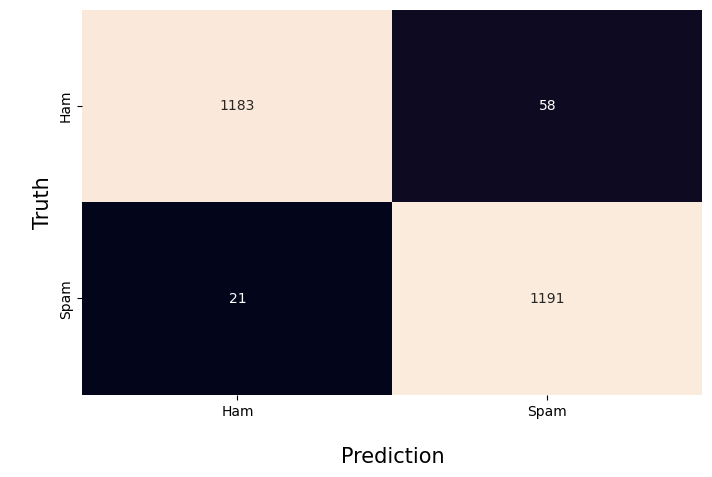

In [70]:
classes = ['Ham','Spam']

plt.figure(figsize = (8,5))
sns.heatmap(cm, annot = True, fmt = 'd', cbar=False).set(xticklabels = classes, yticklabels = classes)
plt.xlabel("\nPrediction", size = 15)
plt.ylabel("\nTruth",  size = 15)
plt.show()

<a id="17"></a>

## <b>17 <span style='color:#4a8fdd'>|</span> MODEL PREDICTION</b>

In [2]:
def predict_category(text):
    text = remove_punctuation(text)
    text = text.lower()
    
    encoded_text = [one_hot(text, VOCAB_SIZE)]
    padded_text = pad_sequences(encoded_text, maxlen=MAX_LEN, padding='post')
    
    pred = (model.predict(padded_text) > 0.5).astype("int32")
    pred = pred.flatten()[0]
    
    return "SPAM" if pred == 1 else "NOT A SPAM"

In [72]:
text = "Get free service and win a prize just call this number 12103239293"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 107ms/step
Text is: Get free service and win a prize just call this number 12103239293

Category: SPAM


In [3]:
text = "congratulation you have won grand prize"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

NameError: name 'remove_punctuation' is not defined

In [74]:
text = "WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! claim"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 78ms/step
Text is: WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! claim

Category: SPAM


In [75]:
text = "Clcik this link to win prize"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 97ms/step
Text is: Clcik this link to win prize

Category: SPAM


In [79]:
text = "Hi, we are going for trip this weekend"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 95ms/step
Text is: Hi, we are going for trip this weekend

Category: SPAM


In [77]:
text = "Did you make a tea?"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 92ms/step
Text is: Did you make a tea?

Category: HAM


In [78]:
text = "Your free trail is going to end, renew it"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 96ms/step
Text is: Your free trail is going to end, renew it

Category: HAM


In [83]:
text = "Contragulation from mobitel .you won the grand prize"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 89ms/step
Text is: Contragulation from mobitel .you won the grand prize

Category: SPAM


In [86]:
import pickle

filename='model.pkl'
pickle.dump(model,open(filename,'wb'))

In [ ]:
loaded_model=pickle.load(open('model.pkl','rb'))

In [ ]:
def predict_category(text):
    text = remove_punctuation(text)
    text = text.lower()
    
    encoded_text = [one_hot(text, VOCAB_SIZE)]
    padded_text = pad_sequences(encoded_text, maxlen=MAX_LEN, padding='post')
    
    pred = (model.predict(padded_text) > 0.5).astype("int32")
    pred = pred.flatten()[0]
    
    return "SPAM" if pred == 1 else "HAM"